In [1]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from emoji import emoji_count
from sklearn import svm
from sklearn import metrics
import string
import statistics as stat
import nltk
from nltk.corpus import cess_esp
from nltk.corpus import words as english_dict
import re
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

In [2]:
def remove_outliers(data,outliers):
    for column,value in zip(outliers.keys(),outliers.values()):
        outliers_index = np.where(data[column] > value)
        data.drop(outliers_index[0], inplace=True)
        data.reset_index(drop=True,inplace=True)

    return data

In [3]:
def data_scaler(data):
    scaler = StandardScaler()
    x = data.values
    x_scaled = scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    return df

In [9]:
def twitter_df():    
    data = pd.read_excel('../cleaned_users.xlsx')
    username_list = data['username']

    num_mentions = []
    num_url = []
    num_hashtags = []
    num_emojis = []

    for username in username_list:
        with open(f'../Documents/{username}.txt','r') as f:
            text = f.read()
            num_mentions.append(text.count('@'))
            num_url.append(text.count('http://') + text.count('https://'))
            num_hashtags.append(text.count('#'))
            num_emojis.append(emoji_count(text))

    data['mentions'] = num_mentions
    data['url'] = num_url
    data['hashtags'] = num_hashtags
    data['emojis'] = num_emojis

    return data

In [10]:
twitter_df = twitter_df()

In [11]:
def df_character_based():    
    data = pd.read_excel('../cleaned_users.xlsx')
    username_list = data['username']

    punctuation_list = list(string.punctuation)

    num_char = []
    num_capital = []
    num_punctuation = []

    for username in username_list:
        with open(f'../Cleaned Documents/{username}.txt','r') as f:
            text = f.read()
            num_char.append(len(text))
            num_capital.append(sum(1 for c in text if c.isupper()))
            num_punctuation.append(sum(1 for c in text if c in punctuation_list))

    data['characters'] = num_char
    data['capital_letters'] = num_capital
    data['punctuations'] = num_punctuation

    return data

In [12]:
char_based_df = df_character_based()

In [13]:
def df_structural_based():    
    data = pd.read_excel('../cleaned_users.xlsx')
    username_list = data['username']

    num_sentence = []
    av_sentence_par = []
    av_words_par = []
    av_char_par = []
    variation = []

    for username in username_list:
        with open(f'../Cleaned Documents/{username}.txt','r') as f:
            text = f.read()
            num_par = len(text.split('\n'))

            sentences = text.split('.')
            num_sentence_user = len(sentences)
            num_sentence.append(num_sentence_user)
            av_sentence_par.append(num_sentence_user/num_par)
            
            words = [w for w in text.split(' ') if len(w) > 0]
            num_words = len(words)
            av_words_par.append(num_words/num_par)
            av_char_par.append(len(text)/num_par)

            len_sentence_list = [len(sentence) for sentence in sentences]
            variation.append(stat.variance(len_sentence_list))     

    data['num_sentence'] = num_sentence
    data['av_sentence_par'] = av_sentence_par
    data['av_words_par'] = av_words_par
    data['av_char_par'] = av_char_par
    data['variation'] = variation

    return data

In [14]:
struct_based_df = df_structural_based()

In [15]:
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ("ü","u"),
        ("ñ","n"),
        ("ç","c"),
        ("\u2026","..."),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [16]:
# remove accents as tweets have them removed
# PoS Tag
def tagger():
    oraciones = cess_esp.tagged_sents()
    oraciones_sin_acentos = []
    for oracion in oraciones:
        oracion_sin_acento = []
        for palabra,tag in oracion:
            palabra = normalize(palabra)
            oracion_sin_acento.append((palabra,tag))
        oraciones_sin_acentos.append(oracion_sin_acento)

    return nltk.UnigramTagger(oraciones_sin_acentos)

In [17]:
# load data for character based features analysis
def df_syntactic_based_ratios():

    data = pd.read_excel('../cleaned_users.xlsx')
    username_list = data['username']

    pos_tag = tagger()

    num_det = []
    num_pre = []
    num_sing = []
    num_plural = []
    num_adv = []
    num_adj = []
    num_prop = []
    num_pronouns = []
    num_past = []
    num_future = []
    num_conj = []

    for username in username_list:
        with open(f'../Cleaned Documents/{username}.txt','r') as f:
            text = f.read()
            # lowercase and remove punctuation marks
            text = text.lower()
            text = text.translate(str.maketrans('','',string.punctuation))
            analysis = pos_tag.tag(text.split(' '))

            num_words = len(analysis)

            det = 0
            pre = 0
            sing = 0
            plural = 0
            adv = 0
            adj = 0
            prop = 0
            pronouns = 0
            past = 0
            future = 0
            conj = 0

            for word,tag in analysis:
                if tag != None:
                    if tag[0] == 'd':
                        det += 1
                    elif tag[0] == 'a':
                        adj += 1
                    elif tag[0] == 'c':
                        conj += 1
                    elif tag[0] == 'p':
                        pronouns += 1
                    elif tag[0] == 'n':
                        if tag[1] == 'p':
                            prop += 1
                        if tag[3] == 's':
                            sing += 1
                        elif tag[3] == 'p':
                            plural += 1
                    elif tag[0] == 'r':
                        adv += 1
                    elif (tag[0] == 'v' and tag[3] == 'f'):
                        future += 1
                    elif (tag[0] == 'v' and tag[3] == 's'):
                        past += 1
                    elif tag[0] == 's':
                        pre += 1

            
            num_det.append(det/num_words)
            num_pre.append(pre/num_words)
            num_sing.append(sing/num_words)
            num_plural.append(plural/num_words)
            num_adv.append(adv/num_words)
            num_adj.append(adj/num_words)
            num_prop.append(prop/num_words)
            num_pronouns.append(pronouns/num_words)
            num_past.append(past/num_words)
            num_future.append(future/num_words)
            num_conj.append(conj/num_words)

    data['ratio_det'] = num_det
    data['ratio_pre'] = num_pre
    data['ratio_sing'] = num_sing
    data['ratio_plural'] = num_plural
    data['ratio_adv'] = num_adv
    data['ratio_adj'] = num_adj
    data['ratio_prop'] = num_prop
    data['ratio_pronouns'] = num_pronouns
    data['ratio_past'] = num_past
    data['ratio_future'] = num_future
    data['ratio_conj'] = num_conj

    return data

In [18]:
synt_based_ratio_df = df_syntactic_based_ratios()

In [19]:
sent_analysis_data = pd.read_csv('../../Spanish-NRC-EmoLex.txt',sep='\t')
spanish_dict = [normalize(w) for w in list(sent_analysis_data['Spanish Word'])]
columns = sent_analysis_data.keys()
negative_cols = ['negative','fear','anger','disgust','sadness']
positive_cols = ['positive','joy','trust']

negative_words = []
for col in negative_cols:
    i = 0
    for val in sent_analysis_data[col]:
        if val == 1:
            negative_words.append(spanish_dict[i])
        i += 1

positive_words = []
for col in positive_cols:
    i = 0
    for val in sent_analysis_data[col]:
        if val == 1:
            positive_words.append(spanish_dict[i])
        i += 1

negative_words = set(negative_words)
positive_words = set(positive_words)

In [20]:
def sent_analysis(words):

    intersection_neg = list(negative_words & set(words))
    intersection_pos = list(positive_words & set(words))

    return len(intersection_pos),len(intersection_neg)

In [21]:
# returns a list of words that occur exactly 'num' times or None if no coincidence
def num_occurences(lista,num):
    aux_dict = {}
    for item in lista:
        if item in aux_dict.keys():
            aux_dict[item] += 1
        else:
            aux_dict[item] = 1

    try:
        idx = list(aux_dict.values()).index(num)
        words = list(aux_dict.keys())[idx]
        return len(words)
    except:
        return 0

In [22]:
# load data for character based features analysis
def df_word_based():

    data = pd.read_excel('../cleaned_users.xlsx')
    username_list = data['username']

    # load spanish stop words
    stop_words_df = pd.read_csv('../../spanish-stop-words.txt',header=None)
    stop_words = [normalize(w) for w in list(stop_words_df[0])]

    num_words = []
    num_pos_words = []
    num_neg_words = []
    num_unique = []
    num_twice = []
    av_length = []
    max_length = []
    num_numbers = []
    num_greater = []
    num_smaller = []
    num_stop = []

    for username in username_list:
        with open(f'../Cleaned Documents/{username}.txt','r') as f:
            text = f.read()
            # remove punctuation
            text = text.translate(str.maketrans('','',string.punctuation))
            sentences = text.split('\n')
            words = []
            for sentence in sentences:
                words += sentence.split(' ')
            words = [w for w in words if len(w) != 0]
            words_lower = [w.lower() for w in words if len(w) != 0]

            num_words.append(len(words))

            pos, neg = sent_analysis(words_lower)

            num_pos_words.append(pos)
            num_neg_words.append(neg)

            # unique words
            num_unique.append(num_occurences(words,1))
            # twice occurrences
            num_twice.append(num_occurences(words,2))
            
            # max, av, >6, <3 length and num words with digits, count english words
            max_len = 0
            sum_length = 0
            digits = 0
            len_greater = 0
            len_smaller = 0
            for word in words:
                sum_length += len(word)
                if len(word) > max_len:
                    max_len = len(word)

                if len(re.findall('\d',word)) > 0:
                    digits += 1

                if len(word) > 6:
                    len_greater += 1
                elif len(word) < 3:
                    len_smaller += 1
            
            av_length.append(sum_length/len(words))
            max_length.append(max_len)
            num_numbers.append(digits)
            num_greater.append(len_greater)
            num_smaller.append(len_smaller)

            # count stop-words 
            intersection_stop = list(set(stop_words) & set(words_lower))
            num_stop.append(len(intersection_stop))


    data['num_words'] = num_words
    data['num_pos_words'] = num_pos_words
    data['num_neg_words'] = num_neg_words
    data['num_unique'] = num_unique
    data['num_twice'] = num_twice
    data['av_length'] = av_length
    data['max_length'] = max_length
    data['num_numbers'] = num_numbers
    data['num_greater'] = num_greater
    data['num_smaller'] = num_smaller
    data['num_stop'] = num_stop

    return data         

In [23]:
word_based_df = df_word_based()

In [24]:
char_df = char_based_df.copy()
struct_df = struct_based_df.copy()
synt_df = synt_based_ratio_df.copy()
word_df = word_based_df.copy()

stylistic_df = pd.concat([char_df,struct_df,synt_df,word_df],axis=1)
stylistic_df = stylistic_df.iloc[:,~stylistic_df.columns.duplicated()]

In [25]:
sf_df = stylistic_df.copy()
tf_df = twitter_df.copy()

combi1_df = pd.concat([sf_df,tf_df],axis=1)
combi1_df = combi1_df.iloc[:,~combi1_df.columns.duplicated()]

In [72]:
def debias_classifier(classifier, data, features, outliers=None, type='binomial', normalize=True, ngram=False):
    aux = features + ['gender']
    data.drop([f for f in data.columns if f not in aux], axis=1, inplace=True)
    if outliers != None:
        data = remove_outliers(data,outliers)
    
    # obtain target variable
    map_dict = {}
    i = 0
    for t in data['gender'].unique():
        map_dict[t] = i
        i += 1
    
    Y = list(data['gender'].map(map_dict))
    data.drop(['gender'], axis=1, inplace=True)

    data = data_scaler(data)
    X = data.values.tolist()

    # separate in train and test
    X, Y = shuffle(X,Y)
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, Y, np.arange(len(data)), stratify=Y, test_size=0.3,random_state=109)

    if classifier == 'svm':
        # Linear Kernel
        clf = svm.SVC(probability=True) 
    
    elif classifier == 'xgboost':
        if type == 'binomial':
            objective = 'binary:logistic'
            clf = xgb.XGBRFClassifier(objective=objective,learning_rate=0.01,n_estimators=200,reg_lambda=1)
        else:
            objective = 'multi:softmax'
            clf = xgb.XGBRFClassifier(objective=objective,learning_rate=0.01,n_estimators=200,reg_lambda=1)

    elif classifier == 'RF':
        clf = RandomForestClassifier(criterion='entropy',max_leaf_nodes=None,min_samples_leaf=4,min_samples_split=4,n_estimators=200)


    clf.fit(X_train,y_train)
    feat_importances = pd.Series(clf.feature_importances_, index=features)
    feat_importances.nlargest(20).plot(kind='barh')

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    new_gender = []
    for prob,pred,test in zip(y_pred_proba,y_pred,y_test):
        if abs(prob[0] - prob[1]) < 0.15:
            new_gender.append('neutral')
        else:
            if pred == test:
                if pred == 1:
                    new_gender.append('male')
                else:
                    new_gender.append('female')
            else:
                new_gender.append('error')

    return indices_test, new_gender



/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_86750/4158918361.py:2: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  outliers_index = np.where(data[column] > value)


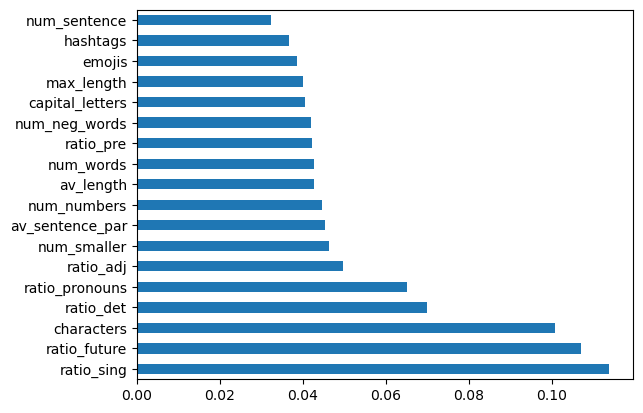

In [73]:
gender_combi1_df = combi1_df.copy()

outliers = {'hashtags':32,
            'emojis':100,
            'characters':24000,
            'capital_letters':800,
            'num_sentence':260,
            'av_sentence_par':2.2,
            'num_words':3200,
            'num_neg_words':110,
            'av_length':6,
            'max_length':52,
            'num_numbers':50,
            'num_smaller':900
            }

features = list(outliers.keys()) + ['ratio_det','ratio_pre','ratio_sing','ratio_adj','ratio_pronouns','ratio_future']

indices_test, new_gender = debias_classifier('xgboost',gender_combi1_df,features,outliers)

In [40]:
gender_list = []
for i in range(len(combi1_df)):
    if i in indices_test:
        idx = np.where(indices_test==i)[0][0]
        gender = new_gender[idx]
        if gender != 'error':
            gender_list.append(gender)
        else:
            gender_list.append(combi1_df.iloc[i:i+1]['gender'].item())

    else:
        gender_list.append(combi1_df.iloc[i:i+1]['gender'].item())

new_combi_df = combi1_df.copy()
new_combi_df['gender'] = gender_list

## Statistical analysis

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import mannwhitneyu,kruskal
from scikit_posthocs import posthoc_dunn

def box_plot(column,data):
    fig,ax = plt.subplots(1,1,figsize=(15,7))

    sns.boxplot(x='gender',y=column,data=data)


def f_cohen(data,mean_list,count_list,total_mean):

    suma = 0
    for mean, count in zip(mean_list,count_list):
        suma += count * math.pow((mean - total_mean),2)

    return math.sqrt(suma/len(data))


def kruskal_posthoc(df,column):
    # Kruskal-Wallis test
    df_aux = df.copy()
    df_aux = df_aux.groupby('gender')[column]
    data = [df_aux.get_group(x).tolist() for x in df_aux.groups]

    data1 = df_aux.get_group('female').tolist()
    data2 = df_aux.get_group('male').tolist()
    data3 = df_aux.get_group('neutral').tolist()

    res = kruskal(data1,data2,data3)
    print(f'GENDER: {res}')

    posthoc = posthoc_dunn(data,p_adjust='holm')
    posthoc = posthoc.set_axis(['female','male','neutral'],axis=0)
    posthoc = posthoc.set_axis(['female','male','neutral'],axis=1)
    print(posthoc)

def statistics(column,data):
    mean_col = data[column].mean()
    # f of Cohen
    # age
    mean_age = data.groupby(['gender'])[column].mean()
    count_age = data.groupby(['gender'])[column].count()
    f_cohen_age = f_cohen(data,mean_age,count_age,mean_col)
    f_cohen_age_normalized = f_cohen_age/(max(mean_age) - min(mean_age))
    print(f'The f of Cohen for gender is: {f_cohen_age}')
    print(f'The f of Cohen normalized for gender is: {f_cohen_age_normalized}')


In [52]:
from collections import Counter
Counter(new_combi_df['gender'])

Counter({'female': 558, 'male': 549, 'neutral': 39})

In [55]:
new_combi_df2 = new_combi_df.drop(['username','age','region'],axis=1)


COLUMN: characters

         count          mean          std     min     25%      50%       75%  \
gender                                                                         
female   558.0  10352.691756  5604.290589   533.0  6169.5   9686.5  13379.75   
male     549.0  11548.479053  5696.012533   554.0  7117.0  10642.0  15409.00   
neutral   39.0  11411.461538  5140.541441  3063.0  7023.0  11443.0  14532.50   

             max  
gender            
female   32145.0  
male     27818.0  
neutral  22519.0  
GENDER: KruskalResult(statistic=12.77245017415664, pvalue=0.001684603445018425)
           female      male   neutral
female   1.000000  0.001325  0.405442
male     0.001325  1.000000  0.998818
neutral  0.405442  0.998818  1.000000
The f of Cohen for gender is: 572.4676264743292
The f of Cohen normalized for gender is: 0.41432748830130867


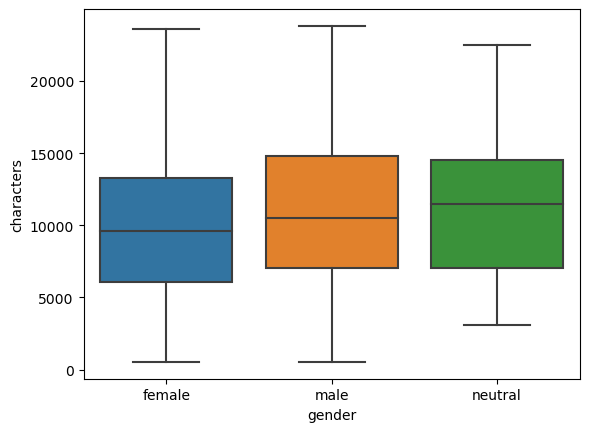


COLUMN: capital_letters

         count        mean         std   min     25%    50%     75%     max
gender                                                                     
female   558.0  365.718638  281.673330   0.0  205.25  323.0  474.25  3645.0
male     549.0  414.535519  279.795750   0.0  243.00  367.0  516.00  2321.0
neutral   39.0  354.102564  189.572205  77.0  202.00  316.0  457.00   911.0
GENDER: KruskalResult(statistic=11.55358270527746, pvalue=0.003098641923608333)
           female      male   neutral
female   1.000000  0.002393  0.953053
male     0.002393  1.000000  0.493998
neutral  0.953053  0.493998  1.000000
The f of Cohen for gender is: 11.752714550106592
The f of Cohen normalized for gender is: 0.4926253213276954


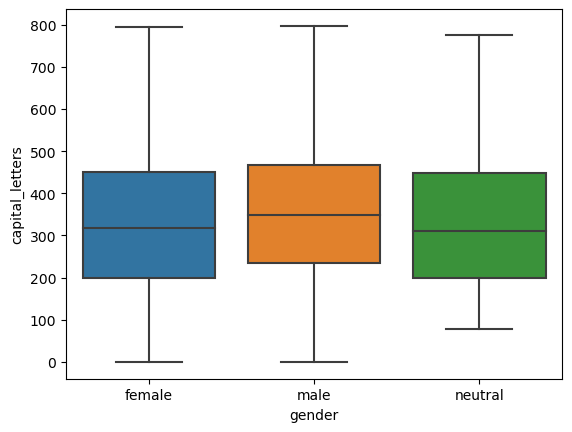


COLUMN: punctuations

         count        mean         std    min     25%    50%     75%     max
gender                                                                      
female   558.0  407.281362  224.158129   26.0  238.25  383.0  529.75  1467.0
male     549.0  417.928962  233.741147   16.0  258.00  388.0  524.00  1737.0
neutral   39.0  400.794872  195.811830  150.0  276.00  392.0  474.50  1083.0
GENDER: KruskalResult(statistic=0.44733970250268357, pvalue=0.799579070827509)
         female  male  neutral
female      1.0   1.0      1.0
male        1.0   1.0      1.0
neutral     1.0   1.0      1.0
The f of Cohen for gender is: 2.2082882087990416
The f of Cohen normalized for gender is: 0.18101035947996863


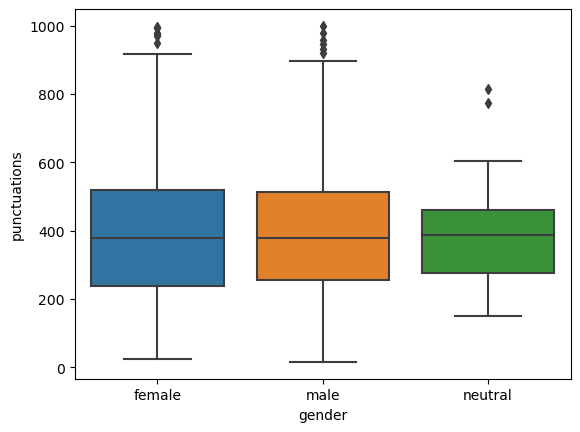


COLUMN: num_sentence

         count        mean        std   min    25%    50%    75%    max
gender                                                                 
female   558.0  132.946237  66.281436   5.0   90.0  123.0  174.0  486.0
male     549.0  161.378871  77.178261   4.0  109.0  161.0  207.0  894.0
neutral   39.0  151.717949  76.133521  56.0   90.0  138.0  187.5  403.0
GENDER: KruskalResult(statistic=48.29303016480658, pvalue=3.2606316703870276e-11)
               female          male   neutral
female   1.000000e+00  1.102102e-11  0.393404
male     1.102102e-11  1.000000e+00  0.393404
neutral  3.934045e-01  3.934045e-01  1.000000
The f of Cohen for gender is: 11.541507504572978
The f of Cohen normalized for gender is: 0.4914280056161548


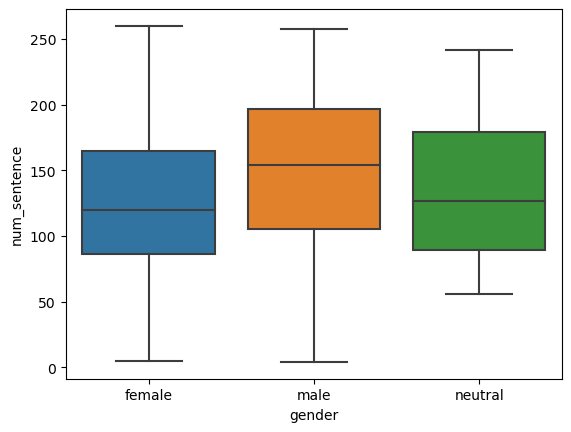


COLUMN: av_sentence_par

         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female   558.0  1.154174  0.536568  0.049020  0.846327  1.029076  1.380714   
male     549.0  1.292433  0.549769  0.039216  0.918660  1.225564  1.607477   
neutral   39.0  1.189110  0.525978  0.434109  0.751771  1.132911  1.446073   

              max  
gender             
female   4.718447  
male     3.830000  
neutral  2.459459  
GENDER: KruskalResult(statistic=27.467405561318273, pvalue=1.0852471806409046e-06)
               female          male   neutral
female   1.000000e+00  5.656948e-07  0.703239
male     5.656948e-07  1.000000e+00  0.262471
neutral  7.032390e-01  2.624713e-01  1.000000
The f of Cohen for gender is: 0.06642651101206257
The f of Cohen normalized for gender is: 0.4926816408649857


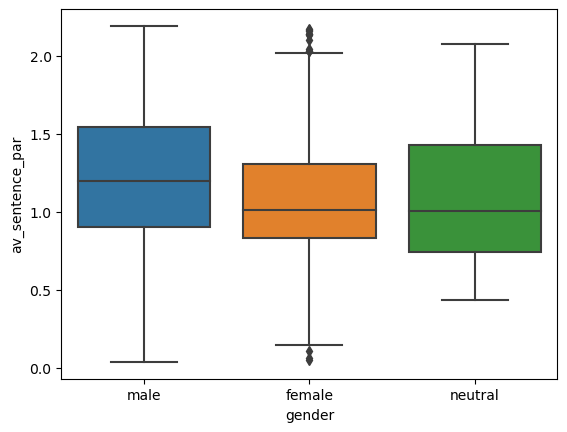


COLUMN: av_words_par

         count       mean       std       min       25%        50%        75%  \
gender                                                                          
female   558.0  12.533271  5.444790  3.486486  8.432660  11.857992  15.420589   
male     549.0  13.844343  5.926420  3.283582  9.400000  12.842105  16.915094   
neutral   39.0  13.972814  6.084606  4.223301  9.248377  13.052356  17.389868   

               max  
gender              
female   31.818898  
male     34.407407  
neutral  32.099099  
GENDER: KruskalResult(statistic=13.900566220909015, pvalue=0.0009583637924743629)
           female      male   neutral
female   1.000000  0.000796  0.312436
male     0.000796  1.000000  0.924963
neutral  0.312436  0.924963  1.000000
The f of Cohen for gender is: 0.6599677426084785
The f of Cohen normalized for gender is: 0.45845658243664295


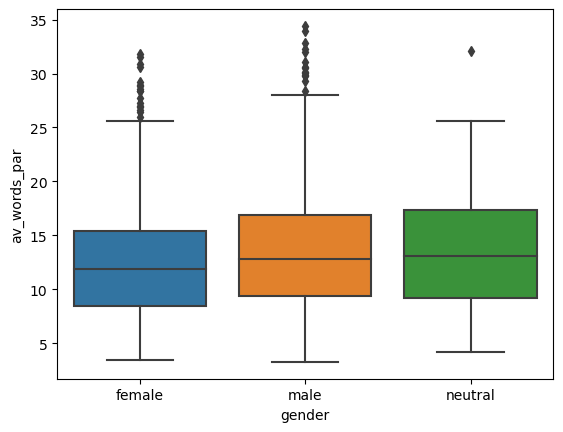


COLUMN: av_char_par

         count       mean        std        min        25%        50%  \
gender                                                                  
female   558.0  84.653760  33.326076  25.969697  60.218468  81.516233   
male     549.0  89.290597  35.072093  28.759615  63.506410  84.013605   
neutral   39.0  88.203194  35.375944  29.737864  63.181865  81.628272   

                75%         max  
gender                           
female   102.855537  202.937500  
male     109.968750  202.740000  
neutral  107.216624  202.873874  
GENDER: KruskalResult(statistic=4.102988147410046, pvalue=0.12854270776654897)
           female      male  neutral
female   1.000000  0.131306      1.0
male     0.131306  1.000000      1.0
neutral  1.000000  1.000000      1.0
The f of Cohen for gender is: 2.2897933988500805
The f of Cohen normalized for gender is: 0.49382657151574266


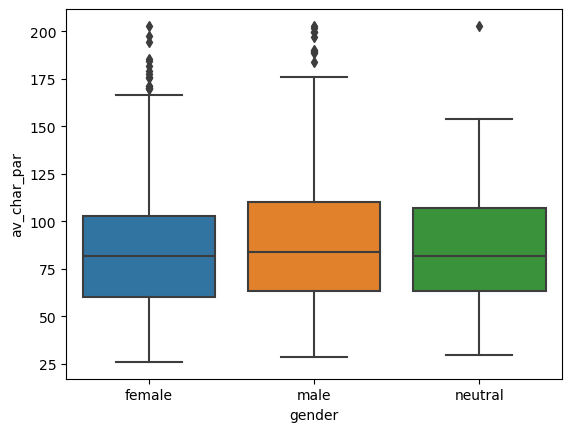


COLUMN: variation

         count          mean            std         min          25%  \
gender                                                                 
female   558.0  31174.438202  285881.714304  355.545549  2408.771428   
male     549.0  11873.742826   39664.976393  224.179406  2368.349478   
neutral   39.0   8172.844203   13975.549127  564.688476  2945.901139   

                 50%          75%           max  
gender                                           
female   4383.032961  9119.277324  4.758090e+06  
male     3869.187422  7178.618430  5.149718e+05  
neutral  3777.182592  7531.940397  7.930171e+04  
GENDER: KruskalResult(statistic=3.413167332938883, pvalue=0.18148474716455607)
           female      male  neutral
female   1.000000  0.196784      1.0
male     0.196784  1.000000      1.0
neutral  1.000000  1.000000      1.0
The f of Cohen for gender is: 9791.979874611534
The f of Cohen normalized for gender is: 0.4257087519682925


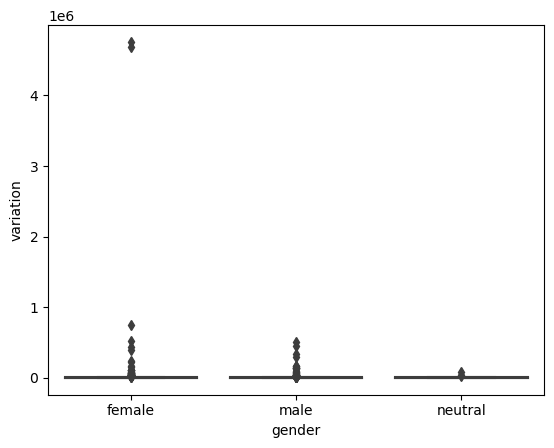


COLUMN: ratio_det

         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female   558.0  0.130783  0.018282  0.034188  0.119619  0.132292  0.143359   
male     549.0  0.135304  0.019054  0.037184  0.126316  0.137129  0.148545   
neutral   39.0  0.133126  0.013409  0.087119  0.126001  0.135052  0.141235   

              max  
gender             
female   0.184283  
male     0.172793  
neutral  0.159778  
GENDER: KruskalResult(statistic=24.613320810151812, pvalue=4.521528737343524e-06)
           female      male   neutral
female   1.000000  0.000002  0.561084
male     0.000002  1.000000  0.561084
neutral  0.561084  0.561084  1.000000
The f of Cohen for gender is: 0.0022214080614695914
The f of Cohen normalized for gender is: 0.4914189161204341


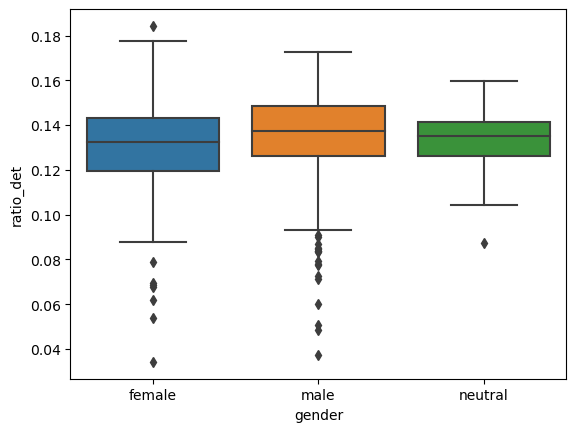


COLUMN: ratio_pre

         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female   558.0  0.137692  0.030968  0.032258  0.115967  0.135249  0.158629   
male     549.0  0.146398  0.028925  0.054726  0.127772  0.144715  0.163793   
neutral   39.0  0.139822  0.030863  0.094780  0.114329  0.138517  0.159024   

              max  
gender             
female   0.254684  
male     0.263584  
neutral  0.205375  
GENDER: KruskalResult(statistic=24.589828812772524, pvalue=4.574951747045628e-06)
           female      male   neutral
female   1.000000  0.000003  0.788711
male     0.000003  1.000000  0.258800
neutral  0.788711  0.258800  1.000000
The f of Cohen for gender is: 0.004296764230885664
The f of Cohen normalized for gender is: 0.4935099695278834


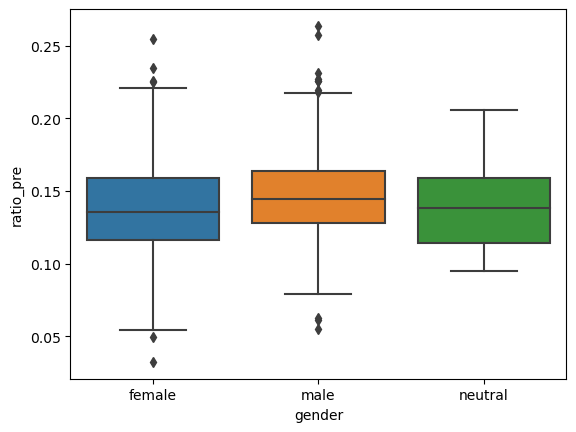


COLUMN: ratio_sing

         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female   558.0  0.103908  0.024033  0.040449  0.088777  0.102958  0.119769   
male     549.0  0.107289  0.022650  0.021277  0.092395  0.106505  0.121986   
neutral   39.0  0.102738  0.020965  0.061846  0.087074  0.101626  0.115717   

              max  
gender             
female   0.165714  
male     0.200000  
neutral  0.158247  
GENDER: KruskalResult(statistic=7.335262543813306, pvalue=0.02553688830584541)
           female      male   neutral
female   1.000000  0.035110  0.603044
male     0.035110  1.000000  0.303022
neutral  0.603044  0.303022  1.000000
The f of Cohen for gender is: 0.0017395504927085806
The f of Cohen normalized for gender is: 0.38229905905731043


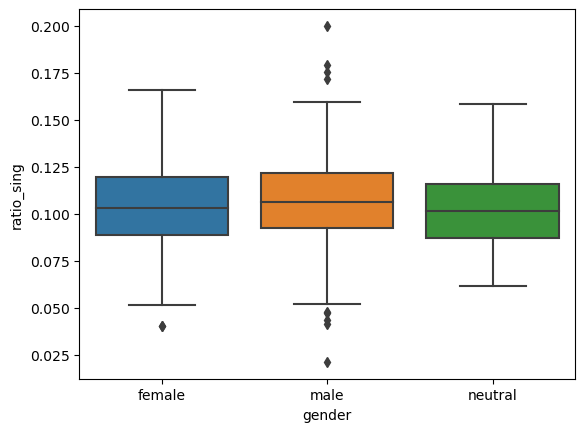


COLUMN: ratio_plural

         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female   558.0  0.034207  0.013428  0.000000  0.024730  0.033359  0.042409   
male     549.0  0.034135  0.012255  0.003145  0.025114  0.033526  0.042017   
neutral   39.0  0.034173  0.014047  0.014520  0.024899  0.029160  0.044430   

              max  
gender             
female   0.119159  
male     0.106169  
neutral  0.078411  
GENDER: KruskalResult(statistic=0.31678127236130277, pvalue=0.8535163024896192)
         female  male  neutral
female      1.0   1.0      1.0
male        1.0   1.0      1.0
neutral     1.0   1.0      1.0
The f of Cohen for gender is: 3.55354787031561e-05
The f of Cohen normalized for gender is: 0.4914228252315635


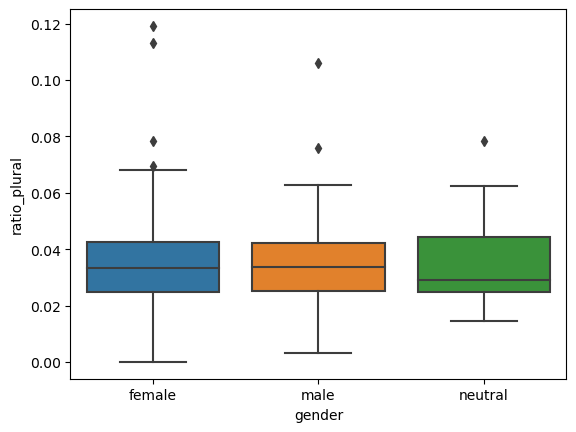


COLUMN: ratio_adv

         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female   558.0  0.047076  0.015499  0.004480  0.036777  0.047945  0.056917   
male     549.0  0.048316  0.016153  0.010753  0.037037  0.049148  0.058201   
neutral   39.0  0.049523  0.015016  0.021955  0.037878  0.051105  0.058546   

              max  
gender             
female   0.112500  
male     0.130636  
neutral  0.075650  
GENDER: KruskalResult(statistic=2.022212870406432, pvalue=0.36381621772687606)
           female      male  neutral
female   1.000000  0.600755  0.80378
male     0.600755  1.000000  0.80378
neutral  0.803780  0.803780  1.00000
The f of Cohen for gender is: 0.00069376825390769
The f of Cohen normalized for gender is: 0.2835321691261169


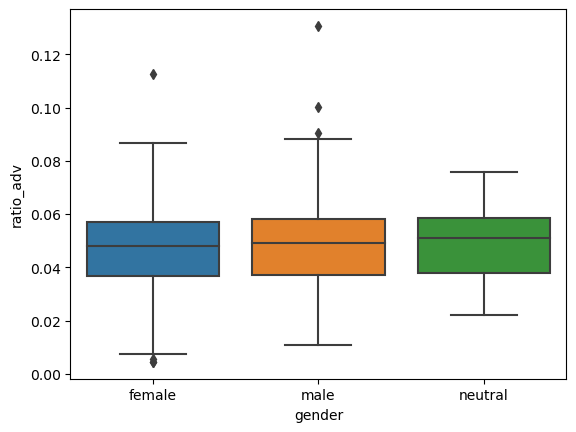


COLUMN: ratio_adj

         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female   558.0  0.042745  0.012187  0.000000  0.035222  0.042671  0.049704   
male     549.0  0.045694  0.012107  0.016484  0.037199  0.045273  0.053686   
neutral   39.0  0.042202  0.011100  0.013793  0.035740  0.041933  0.049734   

              max  
gender             
female   0.093091  
male     0.080640  
neutral  0.062713  
GENDER: KruskalResult(statistic=15.611983489214412, pvalue=0.00040728729190986574)
           female      male   neutral
female   1.000000  0.000349  0.868812
male     0.000349  1.000000  0.236139
neutral  0.868812  0.236139  1.000000
The f of Cohen for gender is: 0.0014941176484356486
The f of Cohen normalized for gender is: 0.4278019394455722


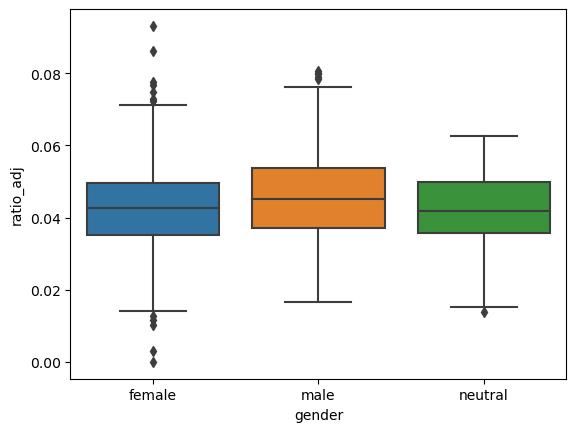


COLUMN: ratio_prop

         count      mean       std  min  25%  50%  75%       max
gender                                                          
female   558.0  0.000053  0.000528  0.0  0.0  0.0  0.0  0.010325
male     549.0  0.000020  0.000214  0.0  0.0  0.0  0.0  0.004513
neutral   39.0  0.000056  0.000278  0.0  0.0  0.0  0.0  0.001671
GENDER: KruskalResult(statistic=2.592032777755336, pvalue=0.2736196190151978)
           female      male   neutral
female   1.000000  0.501723  0.572894
male     0.501723  1.000000  0.572894
neutral  0.572894  0.572894  1.000000
The f of Cohen for gender is: 1.638953041090335e-05
The f of Cohen normalized for gender is: 0.4539702605336184


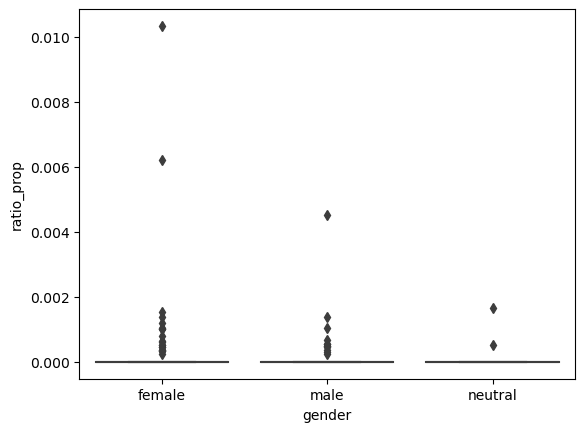


COLUMN: ratio_pronouns

         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female   558.0  0.072310  0.026401  0.009191  0.051887  0.069971  0.092046   
male     549.0  0.069165  0.025210  0.008092  0.050834  0.070188  0.087432   
neutral   39.0  0.073752  0.024624  0.025091  0.055868  0.073103  0.095833   

              max  
gender             
female   0.138655  
male     0.145233  
neutral  0.107827  
GENDER: KruskalResult(statistic=3.595575438285601, pvalue=0.1656649805879722)
           female      male   neutral
female   1.000000  0.280655  0.569490
male     0.280655  1.000000  0.478547
neutral  0.569490  0.478547  1.000000
The f of Cohen for gender is: 0.0016384106741346768
The f of Cohen normalized for gender is: 0.357177451969982


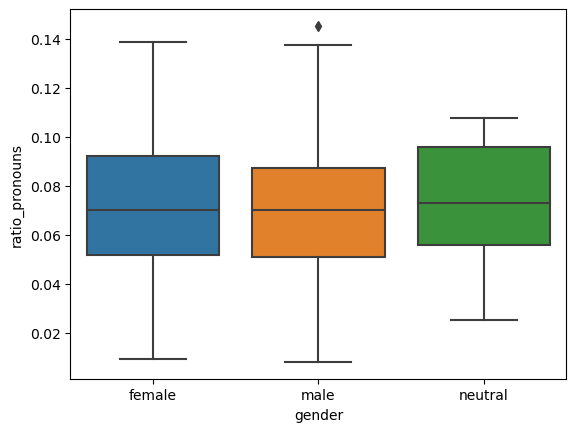


COLUMN: ratio_past

         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female   558.0  0.006080  0.003646  0.000000  0.003486  0.005597  0.008113   
male     549.0  0.006435  0.003772  0.000000  0.003784  0.005839  0.008613   
neutral   39.0  0.005639  0.002775  0.001405  0.004134  0.005420  0.006846   

              max  
gender             
female   0.027454  
male     0.029880  
neutral  0.016092  
GENDER: KruskalResult(statistic=2.752798681440527, pvalue=0.25248603449670365)
           female      male   neutral
female   1.000000  0.444376  0.589440
male     0.444376  1.000000  0.574699
neutral  0.589440  0.574699  1.000000
The f of Cohen for gender is: 0.00020728989051779816
The f of Cohen normalized for gender is: 0.2604272318768585


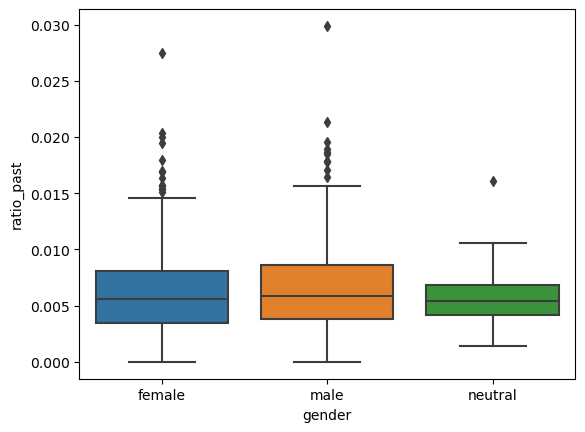


COLUMN: ratio_future

         count      mean       std  min       25%       50%       75%  \
gender                                                                  
female   558.0  0.002023  0.001787  0.0  0.000766  0.001736  0.002957   
male     549.0  0.002473  0.001961  0.0  0.001254  0.002190  0.003293   
neutral   39.0  0.001980  0.001466  0.0  0.000871  0.001903  0.003144   

              max  
gender             
female   0.014599  
male     0.015228  
neutral  0.005892  
GENDER: KruskalResult(statistic=18.834158755893316, pvalue=8.132318709551022e-05)
           female      male   neutral
female   1.000000  0.000050  0.808931
male     0.000050  1.000000  0.373507
neutral  0.808931  0.373507  1.000000
The f of Cohen for gender is: 0.0002262648107679376
The f of Cohen normalized for gender is: 0.45877142502203294


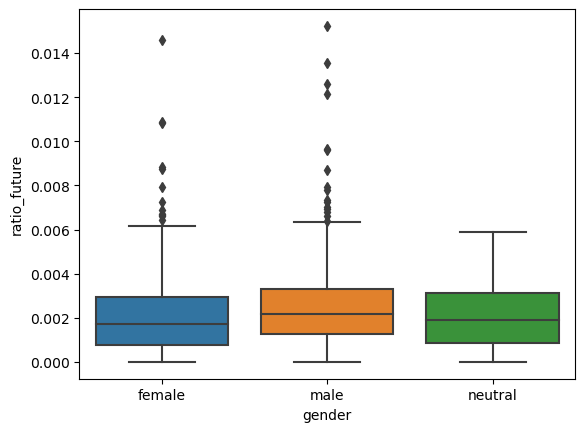


COLUMN: ratio_conj

         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female   558.0  0.043930  0.011267  0.004484  0.036431  0.044288  0.051784   
male     549.0  0.044958  0.010598  0.014733  0.038077  0.044610  0.052083   
neutral   39.0  0.046309  0.010532  0.021680  0.038007  0.047889  0.053688   

              max  
gender             
female   0.079704  
male     0.075157  
neutral  0.063281  
GENDER: KruskalResult(statistic=3.4335293228436004, pvalue=0.1796464257193024)
          female     male  neutral
female   1.00000  0.41976  0.41976
male     0.41976  1.00000  0.41976
neutral  0.41976  0.41976  1.00000
The f of Cohen for gender is: 0.0006085155497276814
The f of Cohen normalized for gender is: 0.25580948013551746


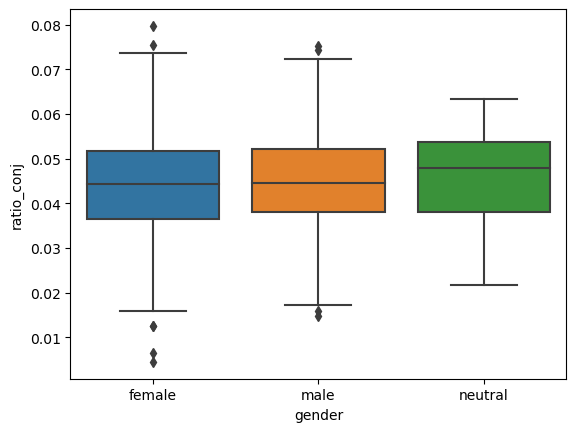


COLUMN: num_words

         count         mean         std    min     25%     50%      75%  \
gender                                                                    
female   558.0  1585.111111  845.128549   82.0   934.0  1492.0  2054.75   
male     549.0  1841.426230  880.412153  101.0  1164.0  1699.0  2468.00   
neutral   39.0  1864.076923  822.619001  530.0  1128.0  1819.0  2448.50   

            max  
gender           
female   4132.0  
male     4304.0  
neutral  3543.0  
GENDER: KruskalResult(statistic=24.78910980257735, pvalue=4.141075996793841e-06)
           female      male   neutral
female   1.000000  0.000004  0.085385
male     0.000004  1.000000  0.786710
neutral  0.085385  0.786710  1.000000
The f of Cohen for gender is: 102.02132531130397
The f of Cohen normalized for gender is: 0.41171007616315014


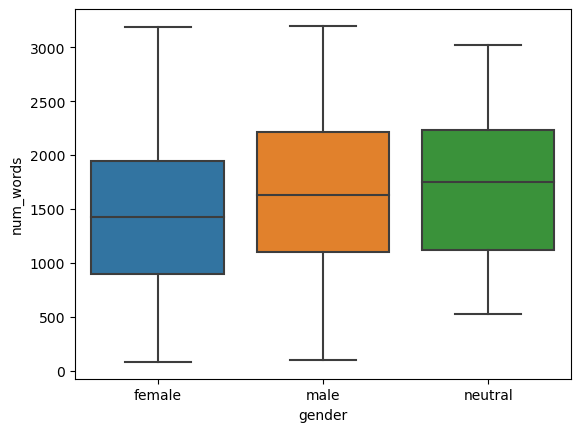


COLUMN: num_pos_words

         count       mean        std   min   25%   50%   75%    max
gender                                                             
female   558.0  61.467742  35.042547   4.0  33.0  57.0  84.0  178.0
male     549.0  70.322404  36.480620   6.0  41.0  65.0  95.0  208.0
neutral   39.0  71.435897  35.117693  17.0  43.5  65.0  91.0  152.0
GENDER: KruskalResult(statistic=18.13482815550609, pvalue=0.00011536447682484553)
           female      male   neutral
female   1.000000  0.000104  0.169596
male     0.000104  1.000000  0.825451
neutral  0.169596  0.825451  1.000000
The f of Cohen for gender is: 4.467140059893026
The f of Cohen normalized for gender is: 0.44814108886119336


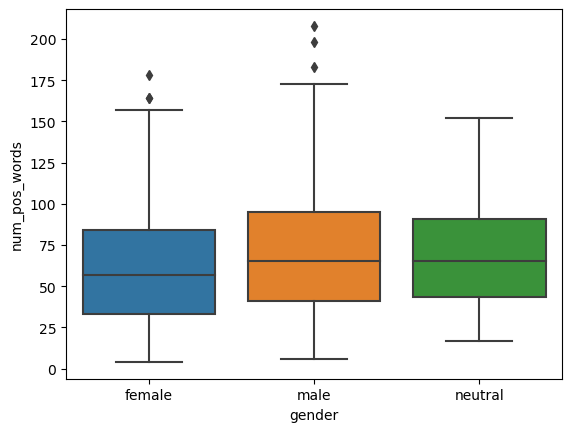


COLUMN: num_neg_words

         count       mean        std   min   25%   50%    75%    max
gender                                                              
female   558.0  41.415771  22.490275   3.0  25.0  38.0  55.75  114.0
male     549.0  48.539162  23.176584   1.0  32.0  45.0  64.00  133.0
neutral   39.0  52.512821  26.208548  16.0  31.0  43.0  69.50  104.0
GENDER: KruskalResult(statistic=29.620730387382824, pvalue=3.6977719303019514e-07)
               female          male   neutral
female   1.000000e+00  5.235253e-07  0.029376
male     5.235253e-07  1.000000e+00  0.586806
neutral  2.937640e-02  5.868065e-01  1.000000
The f of Cohen for gender is: 3.501427516654028
The f of Cohen normalized for gender is: 0.30484855234293246


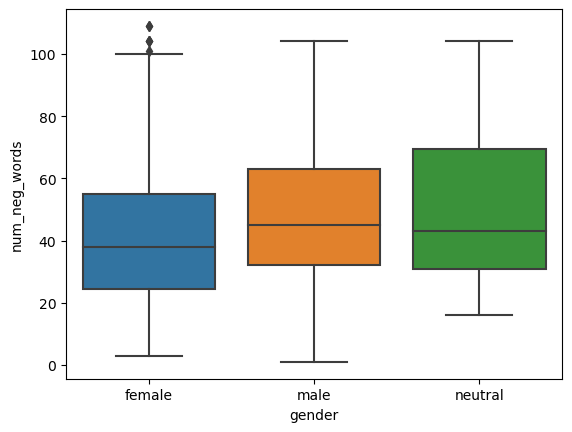


COLUMN: num_unique

         count      mean       std  min  25%  50%  75%   max
gender                                                      
female   558.0  6.182796  3.288453  1.0  4.0  6.0  8.0  29.0
male     549.0  6.825137  3.503182  1.0  5.0  6.0  8.0  31.0
neutral   39.0  6.538462  2.634250  1.0  5.0  7.0  8.0  13.0
GENDER: KruskalResult(statistic=14.351008425472214, pvalue=0.0007650998477377402)
           female      male   neutral
female   1.000000  0.000598  0.338275
male     0.000598  1.000000  0.980119
neutral  0.338275  0.980119  1.000000
The f of Cohen for gender is: 0.31571946900236236
The f of Cohen normalized for gender is: 0.4915138714737656


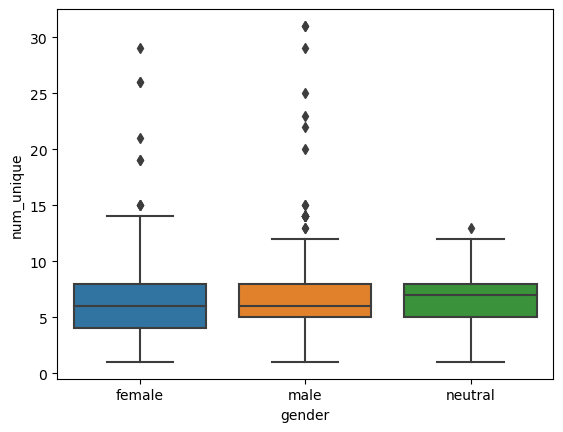


COLUMN: num_twice

         count      mean       std  min  25%  50%  75%   max
gender                                                      
female   558.0  5.632616  3.367840  1.0  3.0  5.0  7.0  29.0
male     549.0  5.719490  3.248470  1.0  4.0  5.0  7.0  29.0
neutral   39.0  5.564103  2.348514  2.0  3.5  5.0  7.0  13.0
GENDER: KruskalResult(statistic=1.21470203455526, pvalue=0.5447921041995601)
           female      male  neutral
female   1.000000  0.980386      1.0
male     0.980386  1.000000      1.0
neutral  1.000000  1.000000      1.0
The f of Cohen for gender is: 0.0472422033526296
The f of Cohen normalized for gender is: 0.30402849894293604


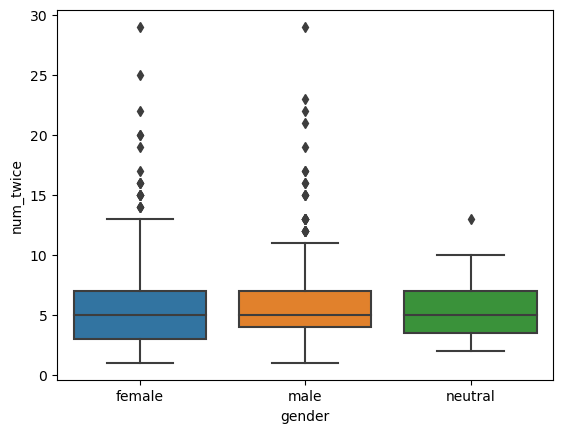


COLUMN: av_length

         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female   558.0  5.236703  0.746043  3.878174  4.708234  5.078888  5.594189   
male     549.0  4.990355  0.680413  3.870122  4.601810  4.857602  5.201862   
neutral   39.0  4.861683  0.456709  4.133728  4.563645  4.820513  5.140332   

               max  
gender              
female   10.003300  
male     10.408616  
neutral   6.034256  
GENDER: KruskalResult(statistic=46.28974511981369, pvalue=8.877885977167418e-11)
               female          male   neutral
female   1.000000e+00  2.963372e-10  0.002407
male     2.963372e-10  1.000000e+00  0.373571
neutral  2.406927e-03  3.735713e-01  1.000000
The f of Cohen for gender is: 0.06047910232340303
The f of Cohen normalized for gender is: 0.3573239886846663


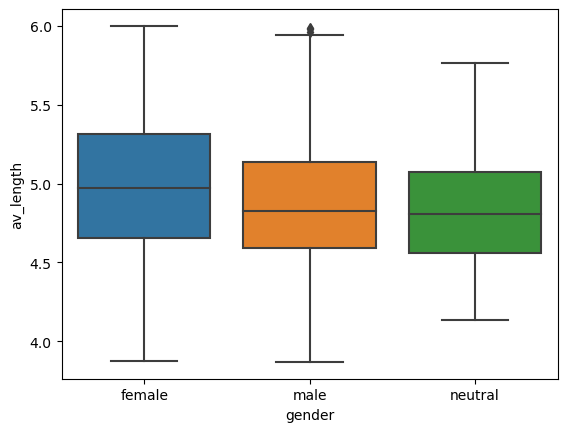


COLUMN: max_length

         count       mean        std   min   25%   50%   75%    max
gender                                                             
female   558.0  35.525090  10.404317  14.0  29.0  34.0  42.0  120.0
male     549.0  32.641166  10.380033  12.0  25.0  31.0  41.0   64.0
neutral   39.0  32.025641   8.570105  16.0  27.0  31.0  36.5   54.0
GENDER: KruskalResult(statistic=20.409090371441735, pvalue=3.7001756046840036e-05)
           female      male   neutral
female   1.000000  0.000042  0.089900
male     0.000042  1.000000  0.668197
neutral  0.089900  0.668197  1.000000
The f of Cohen for gender is: 1.249346733517571
The f of Cohen normalized for gender is: 0.38543457230389677


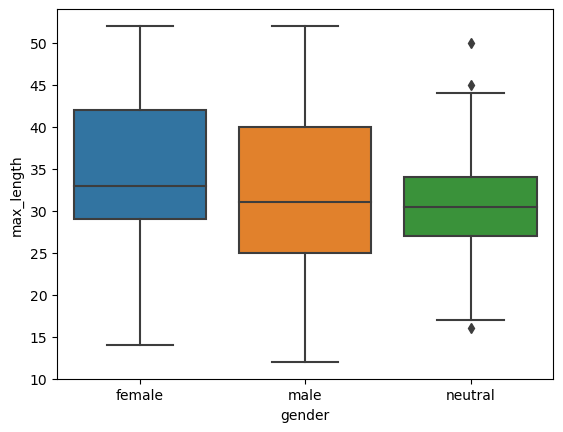


COLUMN: num_numbers

         count       mean        std  min    25%   50%   75%    max
gender                                                             
female   558.0  21.062724  25.371594  0.0   6.25  14.0  26.0  284.0
male     549.0  26.985428  25.460069  0.0  10.00  21.0  37.0  265.0
neutral   39.0  21.025641  13.646837  4.0  11.50  19.0  26.5   74.0
GENDER: KruskalResult(statistic=33.42015922189866, pvalue=5.532286118016135e-08)
               female          male   neutral
female   1.000000e+00  2.642110e-08  0.218271
male     2.642110e-08  1.000000e+00  0.627424
neutral  2.182706e-01  6.274244e-01  1.000000
The f of Cohen for gender is: 1.9795322571535086
The f of Cohen normalized for gender is: 0.46124699334855024


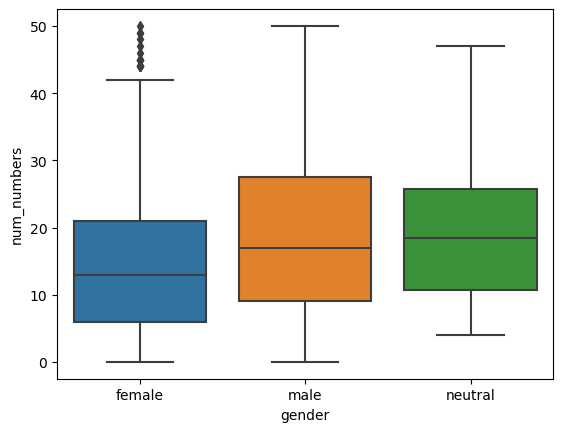


COLUMN: num_greater

         count        mean         std   min     25%    50%    75%     max
gender                                                                    
female   558.0  450.243728  293.062744  20.0  225.25  404.5  603.0  1827.0
male     549.0  501.462659  295.292551  17.0  274.00  445.0  669.0  1399.0
neutral   39.0  489.717949  271.269137  94.0  277.00  426.0  684.5  1092.0
GENDER: KruskalResult(statistic=9.958734786230048, pvalue=0.006878412512558573)
           female      male   neutral
female   1.000000  0.005490  0.588524
male     0.005490  1.000000  0.934451
neutral  0.588524  0.934451  1.000000
The f of Cohen for gender is: 25.298103487036492
The f of Cohen normalized for gender is: 0.4939209508439006


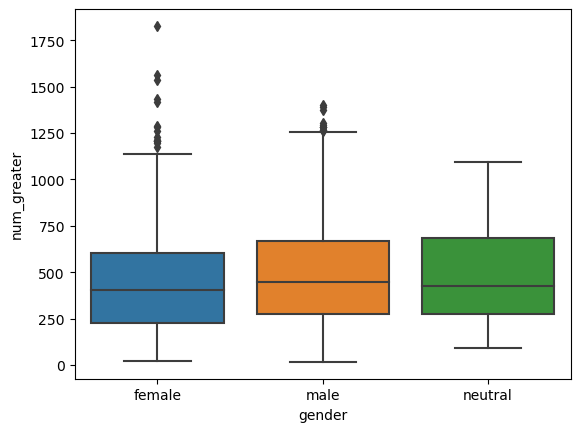


COLUMN: num_smaller

         count        mean         std    min     25%    50%     75%     max
gender                                                                      
female   558.0  468.568100  260.545102   16.0  269.75  432.0  621.75  1399.0
male     549.0  556.422587  269.838266   24.0  346.00  516.0  755.00  1343.0
neutral   39.0  578.743590  257.885911  189.0  360.50  563.0  795.50  1145.0
GENDER: KruskalResult(statistic=33.19653393048225, pvalue=6.186773944528506e-08)
               female          male   neutral
female   1.000000e+00  8.809309e-08  0.022362
male     8.809309e-08  1.000000e+00  0.600179
neutral  2.236245e-02  6.001791e-01  1.000000
The f of Cohen for gender is: 33.74343483258562
The f of Cohen normalized for gender is: 0.3262609296370919


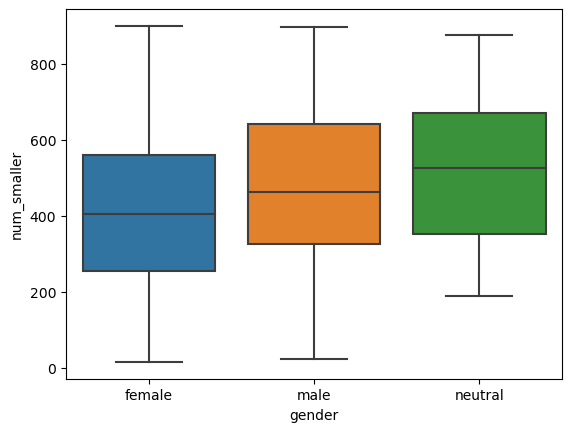


COLUMN: num_stop

         count        mean        std   min    25%    50%     75%    max
gender                                                                  
female   558.0  149.066308  42.654357  28.0  121.0  154.0  179.75  268.0
male     549.0  162.180328  41.288091  32.0  135.0  166.0  192.00  257.0
neutral   39.0  163.076923  38.455979  86.0  133.5  167.0  189.00  247.0
GENDER: KruskalResult(statistic=24.097146225613983, pvalue=5.852901054982856e-06)
           female      male   neutral
female   1.000000  0.000004  0.198573
male     0.000004  1.000000  0.912354
neutral  0.198573  0.912354  1.000000
The f of Cohen for gender is: 6.586425872657073
The f of Cohen normalized for gender is: 0.47010255802991613


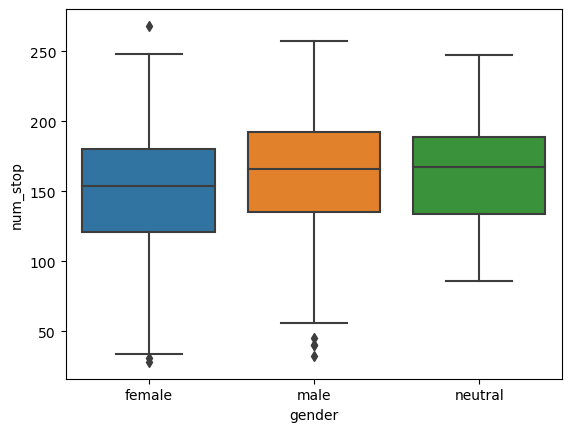


COLUMN: mentions

         count        mean        std  min   25%   50%     75%     max
gender                                                                
female   558.0   94.580645  84.047775  0.0  45.0  79.5  119.75  1031.0
male     549.0   97.081967  94.186541  0.0  52.0  83.0  118.00  1242.0
neutral   39.0  100.256410  72.987280  2.0  52.5  80.0  141.50   313.0
GENDER: KruskalResult(statistic=0.9475634569402943, pvalue=0.6226431430080168)
         female  male  neutral
female      1.0   1.0      1.0
male        1.0   1.0      1.0
neutral     1.0   1.0      1.0
The f of Cohen for gender is: 1.4688410375499037
The f of Cohen normalized for gender is: 0.25879172462807215


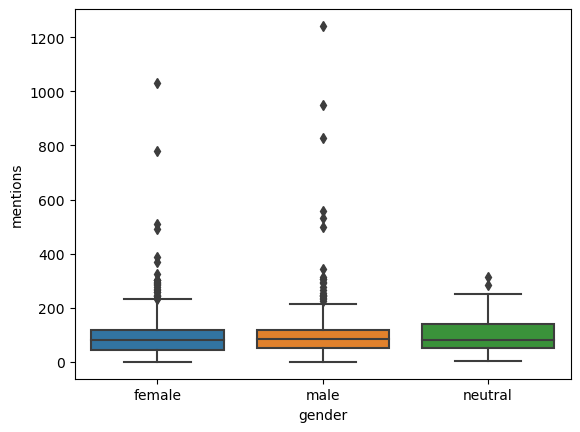


COLUMN: url

         count       mean        std  min   25%   50%   75%    max
gender                                                            
female   558.0  45.105735  32.660727  0.0  16.0  39.5  71.0  187.0
male     549.0  47.652095  33.018645  0.0  20.0  43.0  71.0  199.0
neutral   39.0  44.948718  33.645168  2.0  22.5  36.0  68.5  116.0
GENDER: KruskalResult(statistic=1.8544094769457882, pvalue=0.39565813403595246)
           female      male  neutral
female   1.000000  0.554885      1.0
male     0.554885  1.000000      1.0
neutral  1.000000  1.000000      1.0
The f of Cohen for gender is: 1.2774938502430493
The f of Cohen normalized for gender is: 0.4725548672740042


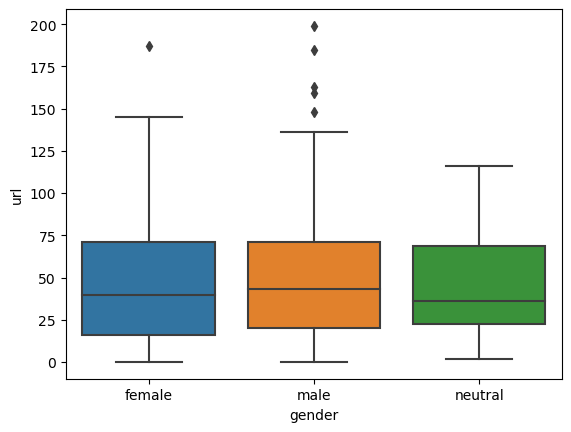


COLUMN: hashtags

         count       mean        std  min  25%  50%   75%     max
gender                                                           
female   558.0  29.107527  91.494627  0.0  0.0  6.0  28.0  1385.0
male     549.0  22.883424  53.811759  0.0  0.0  3.0  18.0   539.0
neutral   39.0  11.871795  19.586756  0.0  0.0  2.0  11.0    62.0
GENDER: KruskalResult(statistic=9.0515132969687, pvalue=0.010826519466926067)
           female      male   neutral
female   1.000000  0.029592  0.094090
male     0.029592  1.000000  0.294294
neutral  0.094090  0.294294  1.000000
The f of Cohen for gender is: 0.7727377280764816
The f of Cohen normalized for gender is: 0.22574214487854805


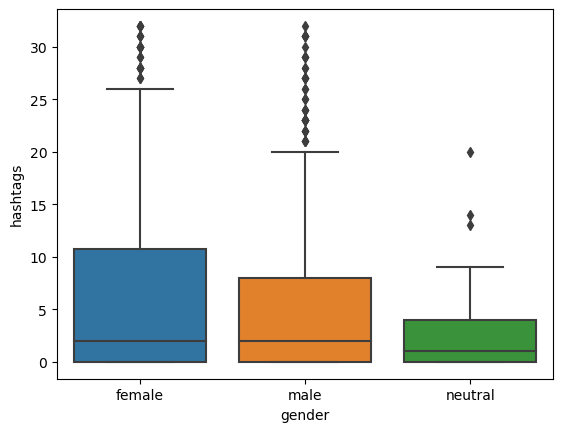


COLUMN: emojis

         count       mean        std  min   25%   50%    75%     max
gender                                                              
female   558.0  59.654122  63.565799  0.0  15.0  39.0  82.75   405.0
male     549.0  40.927140  69.594722  0.0   5.0  19.0  50.00  1048.0
neutral   39.0  40.179487  44.008296  0.0   8.5  17.0  63.50   177.0
GENDER: KruskalResult(statistic=62.433253008188444, pvalue=2.7719881261489048e-14)
               female          male   neutral
female   1.000000e+00  1.063984e-14  0.069778
male     1.063984e-14  1.000000e+00  0.455500
neutral  6.977792e-02  4.554999e-01  1.000000
The f of Cohen for gender is: 5.674392696128379
The f of Cohen normalized for gender is: 0.49125710020147234


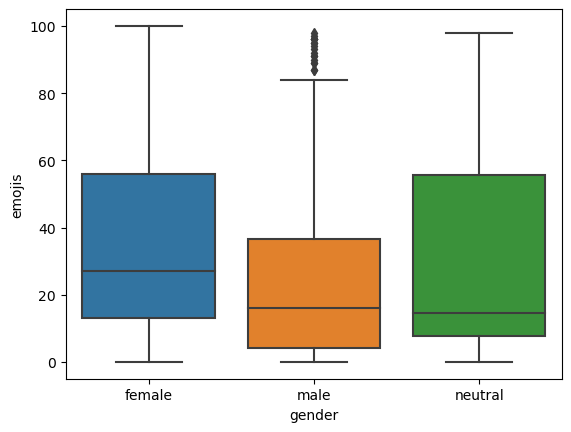

In [62]:
outliers = {'hashtags':32,
            'emojis':100,
            'characters':24000,
            'punctuations':1000,
            'mentions':260,
            'capital_letters':800,
            'num_sentence':260,
            'av_sentence_par':2.2,
            'num_words':3200,
            'num_neg_words':110,
            'av_length':6,
            'av_word_par':27,
            'av_char_par':170,
            'max_length':52,
            'num_numbers':50,
            'num_smaller':900
            }

for c in new_combi_df2.columns:
    if c != 'gender':
        aux_combi = new_combi_df2.copy()

        print(f'\nCOLUMN: {c}\n')
        print(aux_combi.groupby('gender')[c].describe())
        kruskal_posthoc(aux_combi,c)

        if c in outliers.keys():
            outlier = outliers.get(c)
            remove_outliers(aux_combi,c,outlier)
        
        statistics(c,aux_combi)

        sns.boxplot(x='gender',y=c,data=aux_combi)
        plt.show()